# DNACipher inference

Welcome to the inference tutorial for DNACipher, which performs double imputation, i.e. infers variant effects for both unseen sequences and unseen cell type assay combinations (based on a Pytorch model that learns the relationship between sequence, celltype, and assay, enabling any combination of these inputs to infer variant effect). This is visualisation as below:

<img src="https://github.com/BradBalderson/DNACipher/blob/main/img/X1_schematic_logo_github.png" alt="DNACipher Example" width="600">

# NOTE to setup environment locally, did this on an M3 Macbook:

    conda create -n dnacipher_test python=3.10
    conda activate dnacipher_test

    # NOTE am trying to match google collab defaults.
    mamba install jupyterlab
    pip install notebook
    mamba install pytorch::pytorch torchvision torchaudio -c pytorch
    #### See here for torch install instructions: https://pytorch.org/

    mamba install matplotlib
    mamba install pandas
    pip install pyfaidx kipoiseq
    mamba install scipy
    mamba install pytorch-lightning
    
    pip install enformer-pytorch

# Environment Setup

In [1]:
work_dir = '/Users/bradbalderson/Desktop/projects/myPython/DNACipher/'
import os, sys
os.chdir(work_dir)

# Setting this, so that below if component not implemented in Pytorch can fall back to CPU.
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [3]:
##### Importing dependencies
import sys

import torch

import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

import importlib as imp

import pyfaidx

In [4]:
# DNACipher import
import dnacipher.dna_cipher_infer as dnaci
import dnacipher.dna_cipher_model as dnacm
import dnacipher.dna_cipher_plotting as dnapl

In [5]:
#### Paths
data_path = 'tutorials/data/'
weights_path = 'weights/TRAINING_DNACV5_MID-AVG-GENOME_ORIG-ALLOC_ENFORMER0_FINETUNE_STRATMSE_model_weights.pth'
fasta_file_path = f'{data_path}genome.fa'
gtex_vars_path = f'{data_path}gtex_variants_SMALL.vcf'
sample_file_path = f'weights/encode_meta_encode_imputable_filter-fixed_train-test_samp-probs.tsv'

## Detecting GPU for Pytorch

In [10]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("Will use cuda GPU")

elif torch.backends.mps.is_available():
    # device = 'mps:0' # Currently cannot make long-sequence inference with mps:0 due to this:
    # print("Will use apple metal GPU")
    # https://github.com/pytorch/pytorch/issues/134416
    # Should be fixed in future version
    device = 'cpu'
    print('Using CPU, mps available but currently not working for long-sequence inference.')

else:
    device = 'cpu'
    print("No apparent GPU available, using CPU (will be slow).")

device

Using CPU, mps available but currently not working for long-sequence inference.


'cpu'

## Loading the pretrained DNACipher model

In [7]:
# Some extra parameters about the model which cannot be read from the weights:
config = {'activation_function': 'gelu',
          'relu_genome_layer': True, # Is actually gelu, this just means to use activate function for genome layer.
          'layer_norm': True,
          'n_token_features': 3072,
          'relu_output': True,
          'epi_summarise_method': 'flatten',
         }

In [8]:
import importlib as imp
imp.reload(dnacm)
imp.reload(dnaci)

<module 'dnacipher.dna_cipher_infer' from '/Users/bradbalderson/Desktop/projects/myPython/DNACipher/dnacipher/dna_cipher_infer.py'>

In [11]:
dnacipher = dnaci.DNACipher(weight_path=weights_path, sample_file=sample_file_path, config=config,
                            genome_file=fasta_file_path,
                            device=device
                           )

In [12]:
### The attached model
dnacipher.model_

DNACipherModel(
  (celltype_embedding): Embedding(191, 128)
  (assay_embedding): Embedding(202, 256)
  (genome_layer): Linear(in_features=3072, out_features=128, bias=True)
  (dense_layers): ModuleList(
    (0-2): 3 x Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=False)
    )
  )
  (output_layer): Linear(in_features=512, out_features=1, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (loss_function): MSELoss()
)

In [12]:
### Also Enformer, used to generate the sequence embeddings (3072 sequence embedding input)
dnacipher.transformer_model

Enformer(
  (stem): Sequential(
    (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): Residual(
      (fn): Sequential(
        (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): GELU()
        (2): Conv1d(768, 768, kernel_size=(1,), stride=(1,))
      )
    )
    (2): AttentionPool(
      (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
      (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (conv_tower): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): GELU()
        (2): Conv1d(768, 768, kernel_size=(5,), stride=(1,), padding=(2,))
      )
      (1): Residual(
        (fn): Sequential(
          (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): GELU()
          (2): Conv1d(768, 768, kernel_size=(1,), stri

In [13]:
### The cell types / tissues represented
pd.DataFrame( dnacipher.celltypes )

,0
0,A549
1,A673
2,ACC112
3,AG04450
4,B cell
...,...
186,upper lobe of left lung
187,upper lobe of right lung
188,urinary bladder
189,uterus


In [14]:
### The assays represented:
pd.DataFrame( dnacipher.assays )

,0
0,AFF4_ChIP-seq
1,ARID3A_ChIP-seq
2,ARNT_ChIP-seq
3,ASH2L_ChIP-seq
4,ATAC-seq
...,...
197,minus strand total RNA-seq
198,plus strand polyA minus RNA-seq
199,plus strand polyA plus RNA-seq
200,plus strand total RNA-seq


# Data setup

## Downloading reference genome to load sequences from

Download and index the reference genome fasta file

Credit to Genome Reference Consortium: https://www.ncbi.nlm.nih.gov/grc

Schneider et al 2017 http://dx.doi.org/10.1101/gr.213611.116: Evaluation of GRCh38 and de novo haploid genome assemblies demonstrates the enduring quality of the reference assembly

In [ ]:
!mkdir -p {data_path}
!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > {fasta_file_path}
pyfaidx.Faidx(fasta_file_path)
!ls {data_path}

## Loading example GTEX eQTL variant data

Already included small number of example variants

In [15]:
var_df = pd.read_csv(gtex_vars_path, sep='\t', header=0)
var_df.shape, var_df.head(4)

((50, 8),
      CHR       POS REF ALT             GENE_ID  TSS_DIST     SLOPE  \
 0   chr8  31119876   T   C   ENSG00000165392.9     86075  0.337275   
 1  chr13  50909867   G   C  ENSG00000136104.19       189 -1.888380   
 2  chr13  50909048   T   C  ENSG00000136104.19      -630 -1.934090   
 3  chr14  24036431   C   T   ENSG00000225766.9       -22 -1.596800   
 
                      TISSUE  
 0                  Prostate  
 1      Adipose_Subcutaneous  
 2  Adipose_Visceral_Omentum  
 3             Adrenal_Gland  )

# Performing inference on variants.

DNACipher offers a few different interfaces to perform inference of variant effects.

The most specific function takes as input CHR, POS, REF, ALT and also the CELLTYPE, ASSAY and provides effect prediction.

We provide a dictionary below which maps the GTEX tissues to the equivalent ENCODE biosample names:

In [16]:
# GTEX to ENCODE.
tissue_map = {
    'Adipose_Subcutaneous': ['subcutaneous abdominal adipose tissue'],
    'Adipose_Visceral_Omentum': ['omental fat pad'],
    'Adrenal_Gland': ['adrenal gland'],
    'Artery_Aorta': ['aorta', 'ascending aorta', 'thoracic aorta'],
    'Artery_Coronary': ['coronary artery'],
    'Artery_Tibial': ['tibial artery'],
    'Brain_Amygdala': ['brain'],
    'Brain_Anterior_cingulate_cortex_BA24': ['cingulate gyrus'],
    'Brain_Caudate_basal_ganglia': ['caudate nucleus'],
    'Brain_Cerebellar_Hemisphere': ['cerebellum'],
    'Brain_Cerebellum': ['cerebellum'],
    'Brain_Cortex': ['brain'],
    'Brain_Frontal_Cortex_BA9': ['dorsolateral prefrontal cortex'],
    'Brain_Hippocampus': ['layer of hippocampus'],
    'Brain_Hypothalamus': ['brain'],
    'Brain_Nucleus_accumbens_basal_ganglia': ['brain'],
    'Brain_Putamen_basal_ganglia': ['brain'],
    'Brain_Spinal_cord_cervical_c-1': ['spinal cord'],
    'Brain_Substantia_nigra': ['substantia nigra'],
    'Breast_Mammary_Tissue': ['luminal epithelial cell of mammary gland', 'breast epithelium'],
    'Cells_Cultured_fibroblasts': ['foreskin fibroblast', 'fibroblast of dermis', 'fibroblast of lung', 'fibroblast of the aortic adventitia'],
    'Colon_Sigmoid': ['sigmoid colon'],
    'Colon_Transverse': ['transverse colon'],
    'Esophagus_Gastroesophageal_Junction': ['gastroesophageal sphincter'],
    'Esophagus_Mucosa': ['esophagus squamous epithelium'],
    'Esophagus_Muscularis': ['esophagus muscularis mucosa'],
    'Heart_Atrial_Appendage': ['right atrium auricular region'],
    'Heart_Left_Ventricle': ['heart left ventricle'],
    'Kidney_Cortex': ['kidney', 'kidney epithelial cell'],
    'Liver': ['liver', 'right lobe of liver'],
    'Lung': ['lung', 'left lung', 'right lung'],
    'Muscle_Skeletal': ['skeletal muscle tissue', 'muscle of leg', 'muscle of trunk'],
    'Nerve_Tibial': ['tibial nerve'],
    'Ovary': ['ovary'],
    'Pancreas': ['pancreas', 'body of pancreas'],
    'Prostate': ['prostate gland'],
    'Skin_Not_Sun_Exposed_Suprapubic': ['suprapubic skin'],
    'Skin_Sun_Exposed_Lower_leg': ['lower leg skin'],
    'Small_Intestine_Terminal_Ileum': ['small intestine'],
    'Spleen': ['spleen'],
    'Stomach': ['stomach', 'mucosa of stomach'],
    'Testis': ['testis'],
    'Thyroid': ['thyroid gland'],
    'Uterus': ['uterus'],
    'Vagina': ['vagina'],
    'Pituitary': ['brain'], #Edited from here to add in matches for some missing tissues!
    'Whole_Blood': ['peripheral blood mononuclear cell'],
    'Cells_EBV-transformed_lymphocytes': ['B cell'],
    'Minor_Salivary_Gland': ['bronchial epithelial cell']
}

# 1. Inferring variant effect in a particular celltype, assay combination

***We can then use this map to look up our predicted variant effect sizes.***

In [17]:
var_df.head(2)

,CHR,POS,REF,ALT,GENE_ID,TSS_DIST,SLOPE,TISSUE
0,chr8,31119876,T,C,ENSG00000165392.9,86075,0.337275,Prostate
1,chr13,50909867,G,C,ENSG00000136104.19,189,-1.888380,Adipose_Subcutaneous


In [18]:
#### Let's use the example of the WRN locus causal eQTL
chr_, pos, ref, alt = var_df.iloc[0, 0:4]
pos = int(pos)
chr_, pos, ref, alt

('chr8', 31119876, 'T', 'C')

In [19]:
##### BECAUSE we also want to see the gene TSS in the prediction, instead of centring on the variant location
##### we can also specify a new seq centre, as long as it is within 196,608bp from the variant location!
tss_pos = int( pos - var_df.iloc[0, :]['TSS_DIST'] )
seq_pos = (pos+tss_pos) // 2

print(f"eGene TSS: {tss_pos}, sequence-centre-position: {seq_pos}, variant-position: {pos}")

eGene TSS: 31033801, sequence-centre-position: 31076838, variant-position: 31119876


In [20]:
### Getting equivalent cell type represented in DNACipher
celltype = tissue_map[ var_df.values[0, 7] ][0]
celltype

'prostate gland'

***If wanted to input multiple cell types, you can set cell type as a list of cell types, like I'll do with the assays below.***

In [21]:
#### Lets say we just want to look at plus and minus strand RNA-seq
assays = ['plus strand polyA plus RNA-seq', 'minus strand polyA plus RNA-seq'] # Choosing from dnacipher.assays

***Just getting a specific predicted effect for the variant summarised across the input sequence***

In [23]:
# To understand the inputs, see documentation:
?dnacipher.infer_specific_effect

Signature:
dnacipher.infer_specific_effect(
    chr_,
    pos,
    ref,
    alt,
    celltype,
    assay,
    index_base=0,
    return_all=False,
    seq_pos=None,
    full_embeds=True,
    all_combinations=True,
)
Docstring:
Infer the variant effect size for the given celltypes and assays.

Parameters
----------
chr_: str
    Chromosome location of the genetic variant.
pos: int
    Location on the chromosome of the variant.
ref: str
    Reference sequence at the chromosome location.
alt: str
    Alternative sequence at the chromosome location.
celltype: str or list<str>
    A single cell type from within dnacipher.celltypes, or a list of such cell types.
assay: str or list<str>
    A single assay from within dnacipher.assays, or a list of such assays.
index_base: int
    0 or 1, specifies the index-base of the inputted variation position (pos).
return_all: bool
    True to return the signals across the ref and alt sequeneces, the ref and alt sequences, and the latent
    genome repres

In [24]:
strand_effects, experiments_outputted = dnacipher.infer_specific_effect(chr_, pos, ref, alt, celltype, assays,
                                              index_base=1,
                                              seq_pos=seq_pos,
                                              all_combinations=True,
                                             )

In [25]:
### Strand-specific and celltype-specific RNA-seq effect predictions, across the whole inputted locus
for experiment, strand_effect in zip(experiments_outputted, strand_effects):
    print(f"Predicted effect of variant in {experiment}: {strand_effect}")

Predicted effect of variant in ('prostate gland', 'plus strand polyA plus RNA-seq'): 1.7995942831039429
Predicted effect of variant in ('prostate gland', 'minus strand polyA plus RNA-seq'): 0.23777633905410767


***Getting predicted signals for both the reference and alternative sequence across the sequence***

In [26]:
strand_effects, experiments_outputted, ref_signals, alt_signals, ref_seq, alt_seq, ref_features, alt_features = \
                                    dnacipher.infer_specific_effect(chr_, pos, ref, alt, celltype, assays,
                                              index_base=1, seq_pos=seq_pos, all_combinations=True,
                                              # return_all means to return the predict effects along the inputted sequence.
                                              return_all=True,
                                             )

In [27]:
experiments_outputted

[('prostate gland', 'plus strand polyA plus RNA-seq'),
 ('prostate gland', 'minus strand polyA plus RNA-seq')]

***The ref_signals and alt_signals contain the predicted signals for the reference and alternative sequence, respectively***

***Rows specify the position in the sequence, which are 128bp resolution bins, corresponding to the middle 114,688bp of the input sequence***

***Columns specify the predicted experiments, for celltype-assay combination specified by the 'experiments outputted' list***

In [28]:
ref_signals.shape, alt_signals.shape

((896, 2), (896, 2))

***Row 0 corresponds to predicted signal for seq_pos - (114688 / 2) in the genome, and so-on in 128bp bins***

***Visualising the predicted effects, reproducing part of the WRN figure***

In [29]:
# From the 'experiments_outputted', can see that the first column corresponds to the plus strand.
ref_plus_signals = ref_signals[:,0:1]
alt_plus_signals = alt_signals[:,0:1]

ref_minus_signals = ref_signals[:,1:2]
alt_minus_signals = alt_signals[:,1:2]

In [30]:
# Re-scaling to the maximum value observed across the signal for clarity
max_ref_plus = ref_plus_signals.max(axis=0)
ref_plus_signals_normed = (ref_plus_signals / max_ref_plus)
alt_plus_signals_normed = (alt_plus_signals / max_ref_plus)

max_ref_minus = ref_minus_signals.max(axis=0)
ref_minus_signals_normed = (ref_minus_signals / max_ref_minus)
alt_minus_signals_normed = (alt_minus_signals / max_ref_minus)

ref_signals_normed = np.concat((ref_plus_signals_normed, ref_minus_signals_normed), axis=1)
alt_signals_normed = np.concat((alt_plus_signals_normed, alt_minus_signals_normed), axis=1)

In [31]:
# Aesthetics
assay_colors = {'plus strand polyA plus RNA-seq': 'magenta',
                'minus strand polyA plus RNA-seq': 'dodgerblue',
                }
assay_labels = ['plus strand polyA plus RNA-seq', 'minus strand polyA plus RNA-seq']

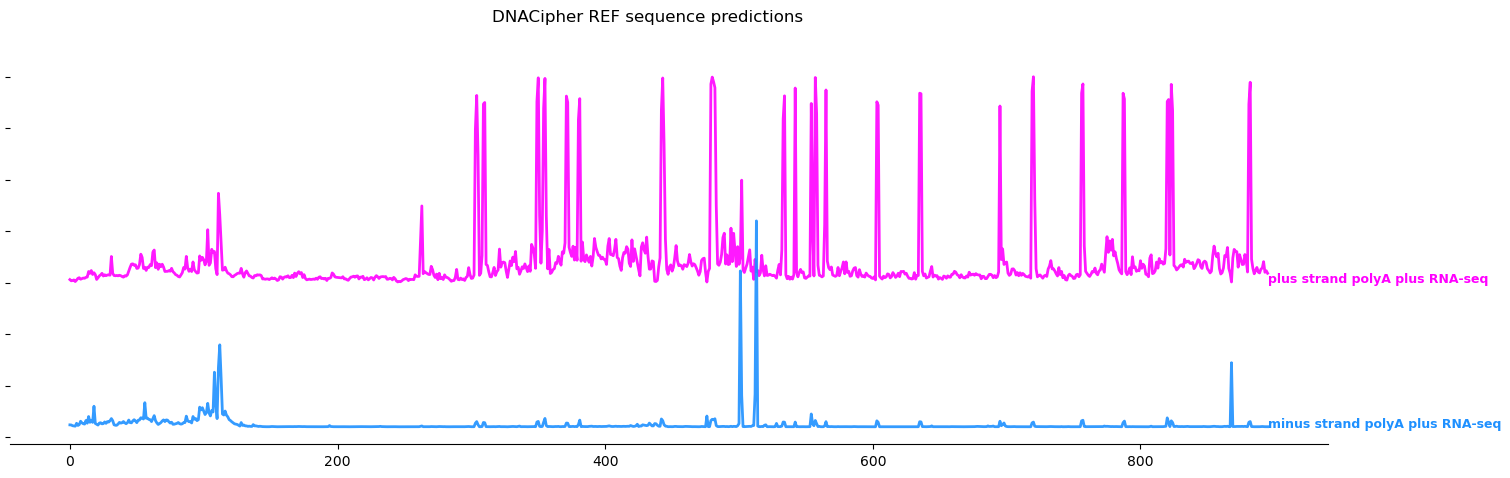

In [32]:
# Squaring since originals were log2, and can see the exons better if put to the unlogged signals.
dnapl.plot_signals(ref_signals_normed**2, assay_labels, assay_colors, show=True,
                   title="DNACipher REF sequence predictions")

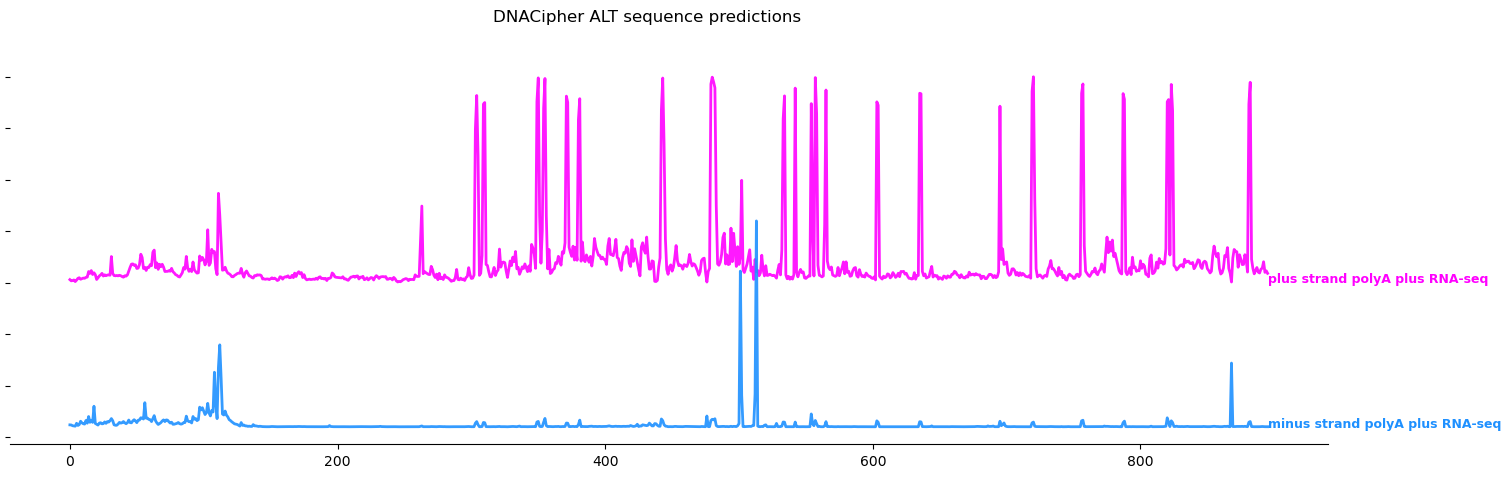

In [33]:
dnapl.plot_signals(alt_signals_normed**2, assay_labels, assay_colors, show=True,
                   title="DNACipher ALT sequence predictions")

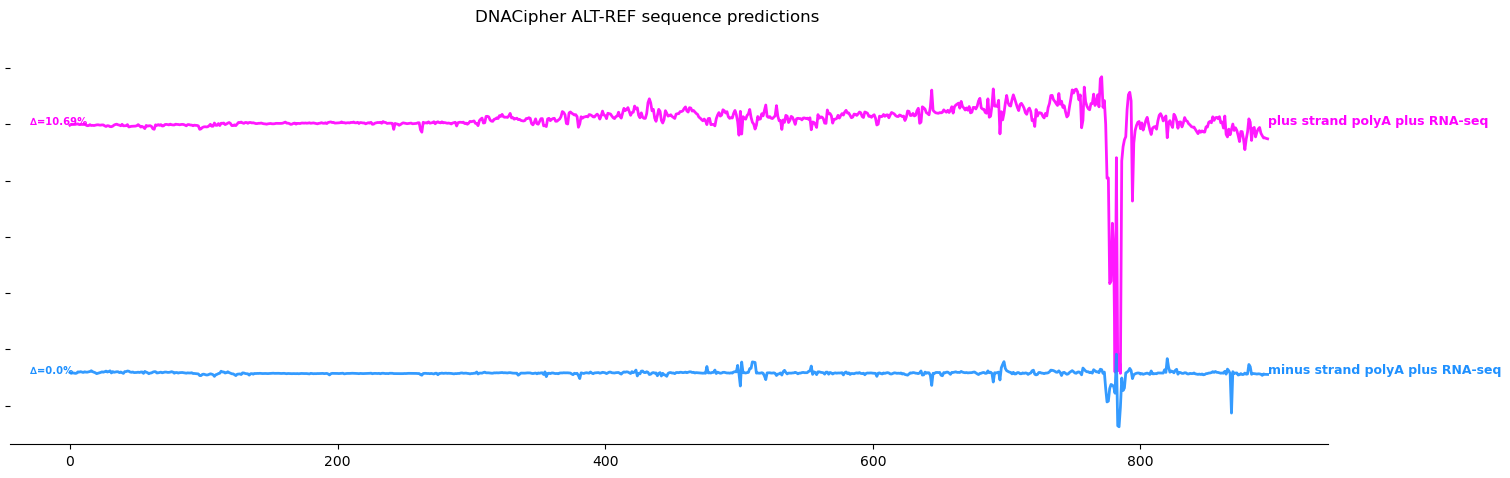

In [34]:
diff_signals = alt_signals_normed - ref_signals_normed
dnapl.plot_signals(diff_signals, assay_labels, assay_colors, show=True, plot_delta=True,
                   title="DNACipher ALT-REF sequence predictions", y_step=-np.max(np.abs(diff_signals)))

## NOTE 

The delta value shown as a percentage, refers to the percentage of the maximum signal seen across the region,
it is not relative to the total signal across the region. In other words, across the whole region we see a net
increase of 10% of the maximum signal expression for the plus-strand, and negligible change for the minus strand.

## Infer effects across ALL cell type and assay combinations

If you have the memory, can predict for all available cell types and assays, by setting
celltype=dnacipher.celltypes and assays=dnacipher.assays using the dnacipher.infer_specific_effect function above, 
but you need ALOT of memory.

Below I have implemented a batched version, so can go through and predict the full matrix of effects in
a batched fashion, relieving high memory requirements, but at the cost of slower inference time.

In [35]:
?dnacipher.infer_effects

Signature:
dnacipher.infer_effects(
    chr_,
    pos,
    ref,
    alt,
    index_base=0,
    batch_size=900,
    batch_axis=1,
    seq_pos=None,
    full_embeds=True,
    verbose=False,
)
Docstring:
Infers effects across all celltype, assays. Using batching strategy to circumvent high memory requirements.

Parameters
----------
chr_: str
    Chromosome location of the genetic variant.
pos: int
    Location on the chromosome of the variant.
ref: str
    Reference sequence at the chromosome location.
alt: str
    Alternative sequence at the chromosome location.
index_base: int
    0 or 1, specifies the index-base of the inputted variation position (pos).
batch_size: int
    The number of experiments or sequence embeddings to parse at a time through the model to predict signals. Lower if run into memory errors.
batch_axis: int
    0 or 1, 1 will batch by experiments, batch_axis=0 will batch by sequence position. Default is best.
seq_pos: int
    Specifies the position to centre the quer

In [36]:
pred_effects = dnacipher.infer_effects(chr_, pos, ref, alt,
                                       batch_axis=1, # Batch by experiments, set batch_axis=0 to do by sequence position. Default better.
                                       batch_size=800, # Impute this number of experiments per batch, if you get a memory error set lower.
                                       index_base=1, seq_pos=seq_pos,
                                       verbose=True,
                                             )

/Users/bradbalderson/Desktop/projects/myPython/DNACipher/dnacipher/dna_cipher_infer.py:719: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_features = torch.tensor(ref_features, device=self.device, dtype=torch.float32)
/Users/bradbalderson/Desktop/projects/myPython/DNACipher/dnacipher/dna_cipher_infer.py:720: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alt_features = torch.tensor(alt_features, device=self.device, dtype=torch.float32)


Finished inference for batch 1 / 49 in 0.076mins
Finished inference for batch 2 / 49 in 0.149mins
Finished inference for batch 3 / 49 in 0.227mins
Finished inference for batch 4 / 49 in 0.308mins
Finished inference for batch 5 / 49 in 0.385mins
Finished inference for batch 6 / 49 in 0.461mins
Finished inference for batch 7 / 49 in 0.542mins
Finished inference for batch 8 / 49 in 0.621mins
Finished inference for batch 9 / 49 in 0.7mins
Finished inference for batch 10 / 49 in 0.778mins
Finished inference for batch 11 / 49 in 0.859mins
Finished inference for batch 12 / 49 in 0.937mins
Finished inference for batch 13 / 49 in 1.015mins
Finished inference for batch 14 / 49 in 1.095mins
Finished inference for batch 15 / 49 in 1.172mins
Finished inference for batch 16 / 49 in 1.249mins
Finished inference for batch 17 / 49 in 1.331mins
Finished inference for batch 18 / 49 in 1.411mins
Finished inference for batch 19 / 49 in 1.492mins
Finished inference for batch 20 / 49 in 1.57mins
Finished inf

***Performed a similar normalisation as the above, except note that the rows and columns will be re-ordered by overall predicted effect***

In [37]:
pred_effects_normed_and_ordered = dnacipher.normalise_and_order_effects(pred_effects)

In [38]:
pred_effects_normed_and_ordered.iloc[0:3,0:3]

,plus strand polyA plus RNA-seq,plus strand polyA minus RNA-seq,plus strand total RNA-seq
mesenchymal stem cell,0.908970,0.818676,0.566118
gastroesophageal sphincter,0.778522,0.663177,0.859750
"CD8-positive, alpha-beta T cell",0.695692,0.413806,0.546977


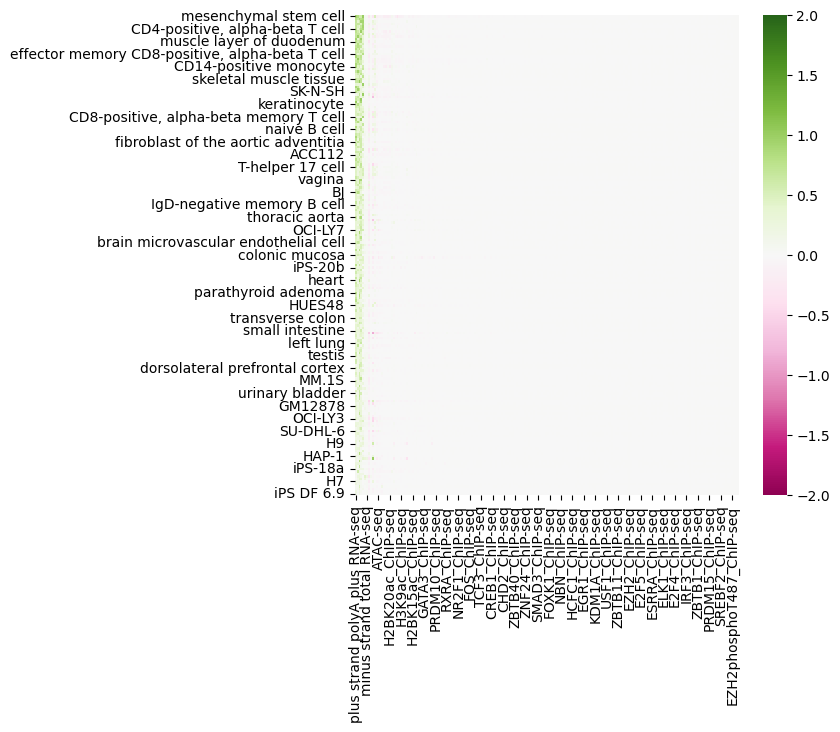

In [40]:
fig, ax = plt.subplots(figsize=(8,8))
sb.heatmap(pred_effects_normed_and_ordered, cmap='PiYG', vmin=-2, vmax=2, #ax=ax
              )
plt.subplots_adjust(bottom=0.35, top=.95, left=0.4, right=1)
plt.show()

## Inferring effects across a set of variants for all celltype, assays

In [41]:
?dnacipher.infer_multivariant_effects

Signature:
dnacipher.infer_multivariant_effects(
    vcf_df,
    index_base=0,
    verbose=True,
    log_file=<ipykernel.iostream.OutStream object at 0x103a56a10>,
    batch_size=900,
    batch_axis=1,
    full_embeds=True,
    seq_pos_col=None,
)
Docstring:
Takes as input a vcf file, in format, CHR, POS, REF, ALT as columns. Outputs a dataframe with rows per
    variant, and predicted effect sizes across the columns for all celltype/assay combinations.

Parameters
----------
vcf: pd.DataFrame
    Rows represent particular genetic variants, columns are CHR, POS, REF, ALT
index_base: int
    0 or 1, specifies the index-base of the inputted variant position (pos).
batch_size: int
    The number of experiments or sequence embeddings to parse at a time through the model to predict signals. Lower if run into memory errors.
batch_axis: int
    0 or 1, 1 will batch by experiments, batch_axis=0 will batch by sequence position. Default is best.
seq_pos_col: int
    Column in vcf that specifies 

In [42]:
var_df.head(3)

,CHR,POS,REF,ALT,GENE_ID,TSS_DIST,SLOPE,TISSUE
0,chr8,31119876,T,C,ENSG00000165392.9,86075,0.337275,Prostate
1,chr13,50909867,G,C,ENSG00000136104.19,189,-1.888380,Adipose_Subcutaneous
2,chr13,50909048,T,C,ENSG00000136104.19,-630,-1.934090,Adipose_Visceral_Omentum


In [43]:
### Can add a column representing the position we want to centre the sequences, if different from the variant position.
### Otherwise will default to centring the sequence on the variant.
tss_positions = (var_df['POS'].values - var_df['TSS_DIST'].values).astype(int)

var_df['seq_pos'] = np.array([var_df['POS'].values, tss_positions]).mean(axis=0).astype( int )
var_df.head(3)

,CHR,POS,REF,ALT,GENE_ID,TSS_DIST,SLOPE,TISSUE,seq_pos
0,chr8,31119876,T,C,ENSG00000165392.9,86075,0.337275,Prostate,31076838
1,chr13,50909867,G,C,ENSG00000136104.19,189,-1.888380,Adipose_Subcutaneous,50909772
2,chr13,50909048,T,C,ENSG00000136104.19,-630,-1.934090,Adipose_Visceral_Omentum,50909363


In [ ]:
var_pred_effects = dnacipher.infer_multivariant_effects(var_df.head(3),
                                              # The positions are 1-based indexing, so have to indicate this
                                              index_base=1, seq_pos_col='seq_pos',
                                             verbose=True,
                                             )

/Users/bradbalderson/Desktop/projects/myPython/DNACipher/dnacipher/dna_cipher_infer.py:719: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_features = torch.tensor(ref_features, device=self.device, dtype=torch.float32)
/Users/bradbalderson/Desktop/projects/myPython/DNACipher/dnacipher/dna_cipher_infer.py:720: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alt_features = torch.tensor(alt_features, device=self.device, dtype=torch.float32)


Finished inference for batch 1 / 43 in 0.091mins
Finished inference for batch 2 / 43 in 0.18mins
Finished inference for batch 3 / 43 in 0.269mins
Finished inference for batch 4 / 43 in 0.36mins
Finished inference for batch 5 / 43 in 0.449mins
Finished inference for batch 6 / 43 in 0.535mins
Finished inference for batch 7 / 43 in 0.622mins
Finished inference for batch 8 / 43 in 0.708mins
Finished inference for batch 9 / 43 in 0.798mins
Finished inference for batch 10 / 43 in 0.888mins
Finished inference for batch 11 / 43 in 0.976mins
Finished inference for batch 12 / 43 in 1.063mins
Finished inference for batch 13 / 43 in 1.149mins
Finished inference for batch 14 / 43 in 1.236mins
Finished inference for batch 15 / 43 in 1.327mins
Finished inference for batch 16 / 43 in 1.416mins
Finished inference for batch 17 / 43 in 1.505mins
Finished inference for batch 18 / 43 in 1.595mins
Finished inference for batch 19 / 43 in 1.683mins
Finished inference for batch 20 / 43 in 1.77mins
Finished inf

In [27]:
var_pred_effects.shape, var_pred_effects.iloc[:, 0:10]

((3, 18336),
                     A549---ATAC-seq  A549---ATF2_ChIP-seq  \
 chr13_50909867_G_C        -0.000281                   0.0   
 chr13_50909048_T_C        -0.005339                   0.0   
 chr14_24036431_C_T         0.019702                   0.0   
 
                     A549---ATF3_ChIP-seq  A549---ATF7_ChIP-seq  \
 chr13_50909867_G_C                   0.0                   0.0   
 chr13_50909048_T_C                   0.0                   0.0   
 chr14_24036431_C_T                   0.0                   0.0   
 
                     A549---BHLHE40_ChIP-seq  A549---BRCA1_ChIP-seq  \
 chr13_50909867_G_C                      0.0                    0.0   
 chr13_50909048_T_C                      0.0                    0.0   
 chr14_24036431_C_T                      0.0                    0.0   
 
                     A549---CEBPB_ChIP-seq  A549---CHD1_ChIP-seq  \
 chr13_50909867_G_C                    0.0                   0.0   
 chr13_50909048_T_C                    0.0   

***We can use reshaping to visualise a specific variants effects:***

In [28]:
### You can reshape to then show the effects of a particular variant:
var0_pred_effects = var_pred_effects.values[2,:].reshape(len(dnacipher.celltypes), len(dnacipher.assays))
var0_pred_effects = pd.DataFrame(var0_pred_effects, index=dnacipher.celltypes, columns=dnacipher.assays)
var0_pred_effects.head(3)

In [ ]:
var0_pred_effects_normed_and_ordered = dnacipher.normalise_and_order_effects(var0_pred_effects)
var0_pred_effects_normed_and_ordered.head(3)

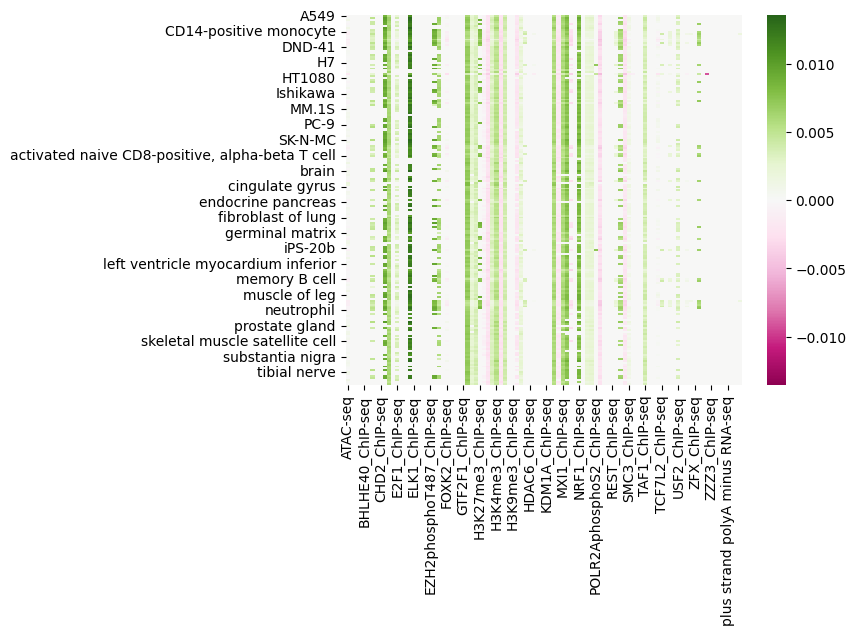

In [29]:
fig, ax = plt.subplots(figsize=(8,8))
sb.heatmap(var0_pred_effects_normed_and_ordered, cmap='PiYG', vmin=-2, vmax=2, #ax=ax
              )
plt.subplots_adjust(bottom=0.35, top=.95, left=0.4, right=1)
plt.show()

***DONE***